# Imports

In [10]:
import torch
import numpy as np
import os
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Globals

In [ ]:
# GLOBALS FOR THE TEXT OF THE CAR PLATE

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

seen = set()    
MY_DICTIONARY = []
for char_list in [provinces, alphabet, ads]:  
    for char in char_list:
        if char not in seen:
            MY_DICTIONARY.append(char)
            seen.add(char)

char2idx = {c: i for i, c in enumerate(MY_DICTIONARY)} # from characters to indices encoding
idx2char = {i: c for i, c in enumerate(MY_DICTIONARY)} # from indices to characters encoding
BLANK_IDX = len(MY_DICTIONARY) 

# FULL DATASETS

test_path="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/test"

# Utils

In [ ]:
# BOUNDING BOX FUNCTION 

def get_bounding_box(file):
    numbers=file.split("-")
    values=numbers[3]
    values_v2=values.split("&")
    values_v3=[]
    for i in range(len(values_v2)):
        if "_" in values_v2[i]:
            values_v3.append(values_v2[i].split("_"))
    t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
    final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
    x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
    y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]
    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_coords)
    y_max = max(y_coords)
    
    return [float(x_min), float(y_min), float(x_max), float(y_max)]

# CAR PLATE TEXT FUNCTION

def get_text(file):
    values=file.split("-")
    text=str(values[4])
    indices=text.split("_")
    province_character=provinces[int(indices[0])]
    alphabet_character=alphabet[int(indices[1])]
    ads_charachters=[ads[int(i)] for i in indices[2:]]
    plate_text=province_character+alphabet_character+"".join(ads_charachters)
    
    return plate_text

# FUNCTION TO LOAD THE DETECTION MODEL

def load_Fasterrcnn(device):
    model = fasterrcnn_resnet50_fpn(num_classes=2)  
    model.load_state_dict(torch.load('model_weights/best_frcnn_model_final_version.pth', map_location="cpu"))
    model.to(device)
    model.eval()
    return model

model=load_Fasterrcnn("cpu")
device="cpu"

# CROP FUNCTIONS WITH PREDICTED BOUNDING BOX

def crop_image_with_RCNN(file):
    image = Image.open(file).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        prediction = model(img_tensor)[0]
        if len(prediction['boxes']) == 0:
            print(f"No box found for image: {file}")
            return None
        best_bb = prediction['boxes'][0].to(device).int()
        cropped = img_tensor[0, :, best_bb[1]:best_bb[3], best_bb[0]:best_bb[2]]
        cropped_resized = F.interpolate(cropped.unsqueeze(0), size=(64, 256), mode='bilinear', align_corners=False)  # slightly different from the usual function, here we reshape to (64,256) so to match CRNN input shape
        return cropped_resized.squeeze(0)  

def crop_folder_with_RCNN(folder_path):
    cropped_folder = []
    files = os.listdir(folder_path)
    for file in files:
        full_path = os.path.join(folder_path, file)
        gt_text=get_text(full_path)
        cropped_image = crop_image_with_RCNN(full_path)
        if cropped_image is not None:
            cropped_folder.append([cropped_image, gt_text])
    return cropped_folder

def ctc_greedy_decoder(output, idx2char, blank=BLANK_IDX):
    out = output.permute(1, 0, 2)  
    pred_strings = []
    for probs in out:
        pred = probs.argmax(1).cpu().numpy()
        prev = -1
        pred_str = []
        for p in pred:
            if p != blank and p != prev:
                pred_str.append(idx2char[p])
            prev = p
        pred_strings.append(''.join(pred_str))
    return pred_strings

/tmp/ipykernel_11096/713015860.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights/best_frcnn_model_final_version.pth', map_

# Data

In [ ]:
# CROPPING THE DATASET

model=load_Fasterrcnn("cpu")
eval_cropped_folder=crop_folder_with_RCNN(test_path)  

/tmp/ipykernel_11096/713015860.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights/best_frcnn_model_final_version.pth', map_

In [ ]:
# DATASET CLASS

class dataset_for_detection_and_recognition(Dataset):

    def __init__(self, dataset, trans):
        self.dataset = dataset
        self.trans = trans

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        text = self.dataset[idx][1]
        
        if self.trans:
            image = self.trans(image)

        text_indices = torch.tensor([char2idx[c] for c in text], dtype=torch.long)
        
        return image, text_indices

# COLLATE FUNCTION

def ctc_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths

# TRANSFORMATIONS

transform = T.Compose([
    T.Grayscale(num_output_channels=1),  
    T.Normalize(mean=[0.5], std=[0.5])  
])

eval_dataset=dataset_for_detection_and_recognition(eval_cropped_folder, trans=transform)
eval_dataloader=DataLoader(eval_dataset, batch_size=32, shuffle=True, collate_fn=ctc_collate_fn)

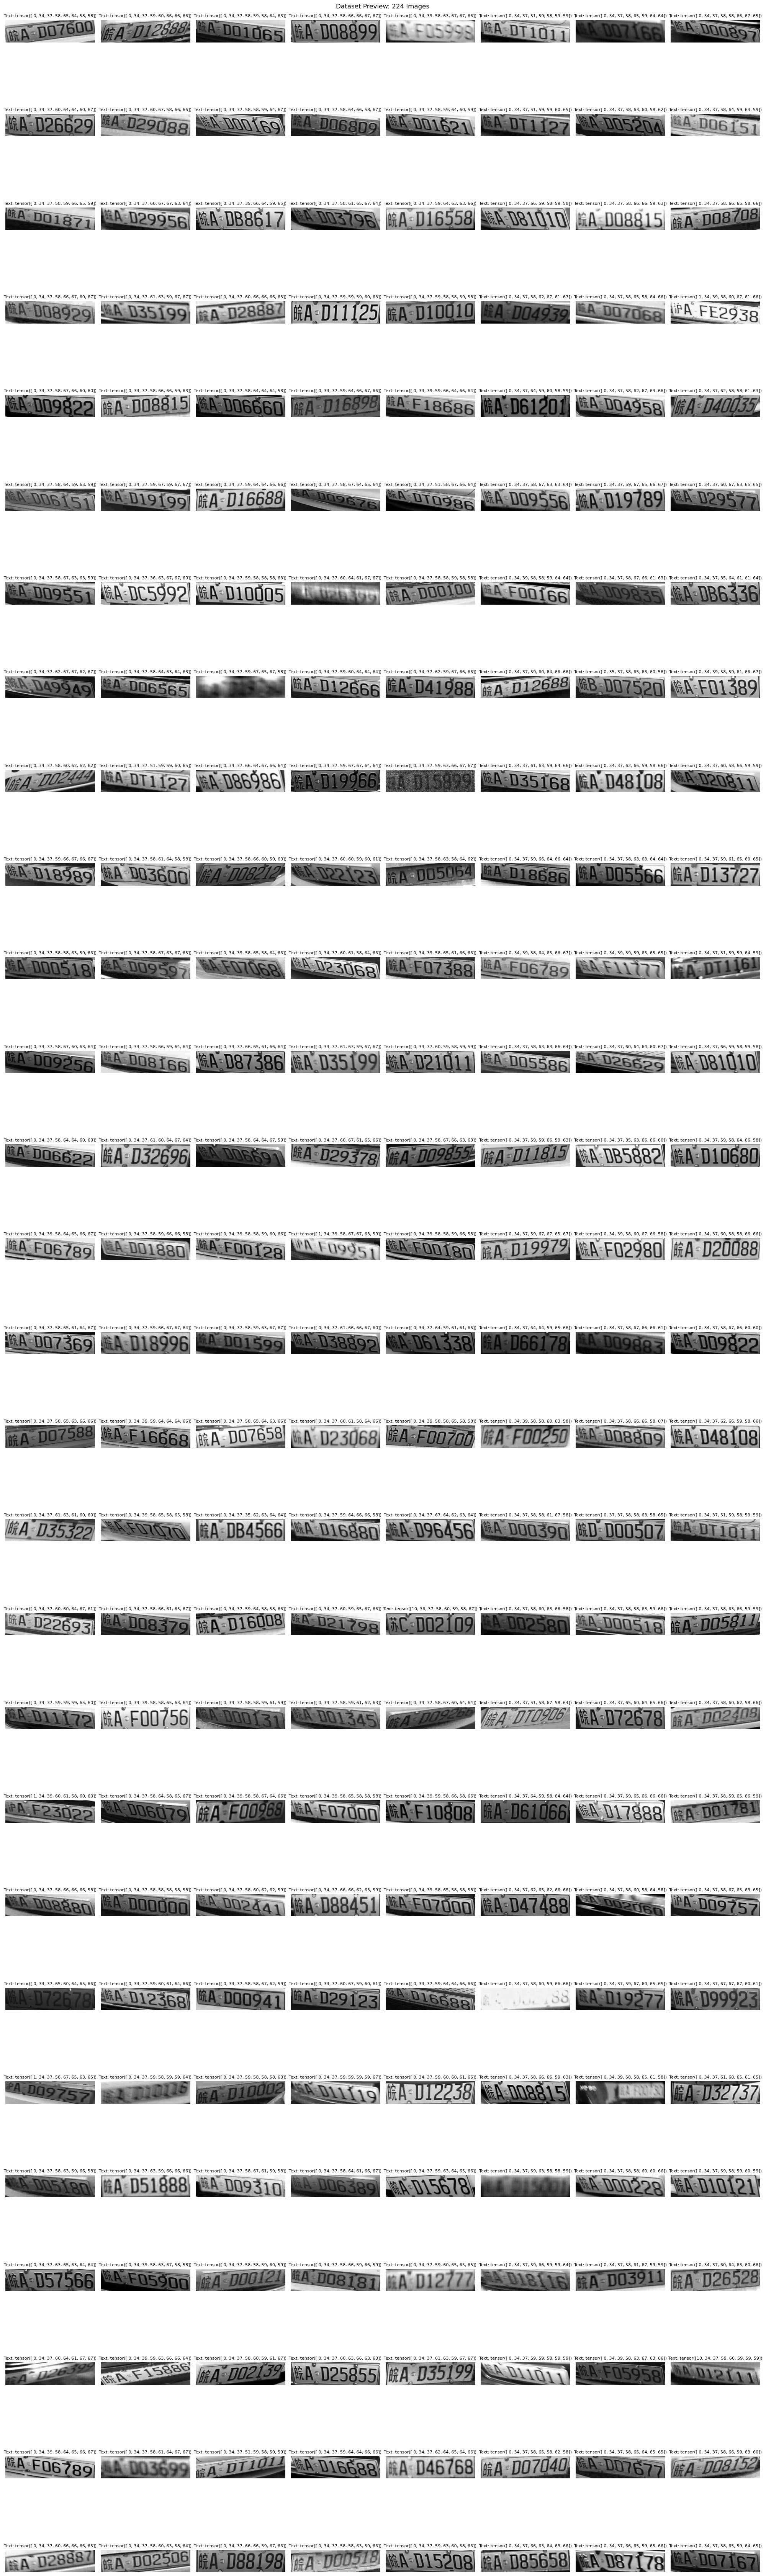

In [28]:
# VISUALIZING THE CROPPED AND TRANSFORMED IMAGES

total_images = len(eval_dataset)
rows = (total_images + 7) // 8  
plt.figure(figsize=(20, rows * 2.5))

for idx, (image, text) in enumerate(eval_dataset):
    plt.subplot(rows, 8, idx + 1)
    img = image.squeeze() 
    img = img * 0.5 + 0.5  # Denormalize using the correct values
    img = torch.clamp(img, 0, 1)  
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f'Text: {text}', fontsize=8)
    plt.axis('off')

plt.suptitle(f'Dataset Preview: {total_images} Images', fontsize=12)
plt.tight_layout()
plt.show()

# Network

In [ ]:
# RECOGNITION MODEL ARCHITECTURE

class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  
        )
        self.rnn = nn.LSTM(256, 128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(128*2, num_classes)  

    def forward(self, x):
        x = self.cnn(x)  
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  
        x, _ = self.rnn(x)
        x = self.fc(x) 

        return x  
    
num_classes = len(MY_DICTIONARY) + 1 
recognition_model = CRNN(num_classes=num_classes, input_channels=1)

# LOADING THE TRAINED MODEL

model_path = "/home/filippo/Documents/Visual Studio Code/best_crnn_ctc_model.pth"
checkpoint = torch.load(model_path, map_location=device)
recognition_model.load_state_dict(checkpoint['model_state_dict']) 
recognition_model.to(device)
recognition_model.eval()

/tmp/ipykernel_11096/425336892.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, None))
  )
  (rnn): LSTM(256, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=69, bias=True)
)

# Train

In [ ]:
# THERE IS NO NEED TO TRAIN ANYTHING HERE SINCE WE JUST HAVE TO MAKE INFERENCE WITH THE DETECTION AND RECOGNITION MODEL

# Evaluation

In [ ]:
# EVALUATING THE RESULTS ON THE CROPPED IMAGES

def evaluate(model, dataloader, device, verbose=False):
    model.eval()
    total = 0
    correct = 0
    total_chars = 0
    correct_chars = 0

    length_errors = 0
    province_correct = 0
    alphabet_correct = 0

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)
            labels_cpu = labels.cpu().numpy()   
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            for pred, gt in zip(pred_strings, gt_strings):
                if pred == gt:
                    correct += 1
                total += 1

                min_len = min(len(pred), len(gt))
                correct_chars += sum([p == g for p, g in zip(pred[:min_len], gt[:min_len])])
                total_chars += len(gt)

                if len(pred) != len(gt):
                    length_errors += 1
                
                if len(pred) > 0 and len(gt) > 0 and pred[0] == gt[0]:
                    province_correct += 1
                
                if len(pred) > 1 and len(gt) > 1 and pred[1] == gt[1]:
                    alphabet_correct += 1

                if verbose and pred != gt and batch_idx == 0:
                    print(f"Pred: '{pred}' | GT: '{gt}'")

    acc = correct / total if total > 0 else 0
    acc_char = correct_chars / total_chars if total_chars > 0 else 0
    length_error_rate = length_errors / total if total > 0 else 0
    province_acc = province_correct / total if total > 0 else 0
    alphabet_acc = alphabet_correct / total if total > 0 else 0

    print(f"Eval accuracy (full plate): {acc:.4f} | Char accuracy: {acc_char:.4f}")
    print(f"Length error rate: {length_error_rate:.4f} | Province acc: {province_acc:.4f} | Alphabet acc: {alphabet_acc:.4f}")

    return acc, acc_char

test_acc, test_acc_char = evaluate(recognition_model, eval_dataloader, device, verbose=True)

Running evaluation...
Pred: '皖AF15888' | GT: '皖AF15886'
Pred: '皖AF15888' | GT: '皖AF15886'
Eval accuracy (full plate): 0.9420 | Char accuracy: 0.9872
Length error rate: 0.0179 | Province acc: 0.9866 | Alphabet acc: 1.0000
Eval accuracy (full plate): 0.9420 | Char accuracy: 0.9872
Length error rate: 0.0179 | Province acc: 0.9866 | Alphabet acc: 1.0000
